In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
# Load the cleaned data
housing_data = pd.read_csv("Clean_Data/mls_th_cleaned.csv")
housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt
0,2372641,Raleigh,27607,5,8,9376,2,2022,2021-03-16,2022-02-23,1850000,324999,344,-1525001,35.8014,-78.6877,2,34.662863
1,2410217,Whitsett,27377,5,7,6983,8,1883,2021-09-27,2023-01-09,1300000,3240000,469,1940000,36.0330,-79.5972,1,463.983961
2,2375877,Wake Forest,27587,5,5,7200,7,2005,2021-04-05,2021-05-27,1800000,2900000,52,1100000,35.9815,-78.5392,2,402.777778
3,2378933,Raleigh,27615,5,7,6289,3,2022,2021-04-20,2022-09-28,2550000,3577591,526,1027591,35.8887,-78.6393,2,568.864843
4,2495996,Apex,27502,4,6,7266,5,2023,2023-02-21,2023-11-21,1755900,2598548,273,842648,35.7225,-78.8408,4,357.631159


In [3]:
# Convert date columns to datetime
housing_data['List Date'] = pd.to_datetime(housing_data['List Date'])
housing_data['Closing Date'] = pd.to_datetime(housing_data['Closing Date'])

In [4]:
# Extracting year and month from List Date and Closing Date
housing_data['List Year'] = housing_data['List Date'].dt.year
housing_data['List Month'] = housing_data['List Date'].dt.month
housing_data['Closing Year'] = housing_data['Closing Date'].dt.year
housing_data['Closing Month'] = housing_data['Closing Date'].dt.month

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month
0,2372641,Raleigh,27607,5,8,9376,2,2022,2021-03-16,2022-02-23,...,344,-1525001,35.8014,-78.6877,2,34.662863,2021,3,2022,2
1,2410217,Whitsett,27377,5,7,6983,8,1883,2021-09-27,2023-01-09,...,469,1940000,36.0330,-79.5972,1,463.983961,2021,9,2023,1
2,2375877,Wake Forest,27587,5,5,7200,7,2005,2021-04-05,2021-05-27,...,52,1100000,35.9815,-78.5392,2,402.777778,2021,4,2021,5
3,2378933,Raleigh,27615,5,7,6289,3,2022,2021-04-20,2022-09-28,...,526,1027591,35.8887,-78.6393,2,568.864843,2021,4,2022,9
4,2495996,Apex,27502,4,6,7266,5,2023,2023-02-21,2023-11-21,...,273,842648,35.7225,-78.8408,4,357.631159,2023,2,2023,11


In [5]:
# Handling outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

for col in ['List Price', 'Sold Price', 'SqFt', 'Days on Market', 'Price per SqFt']:
    handle_outliers(housing_data, col)

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month
0,2372641,Raleigh,27607,5,8,4660.0,2,2022,2021-03-16,2022-02-23,...,215.5,-1525001,35.8014,-78.6877,2,51.610706,2021,3,2022,2
1,2410217,Whitsett,27377,5,7,4660.0,8,1883,2021-09-27,2023-01-09,...,215.5,1940000,36.0330,-79.5972,1,340.702297,2021,9,2023,1
2,2375877,Wake Forest,27587,5,5,4660.0,7,2005,2021-04-05,2021-05-27,...,52.0,1100000,35.9815,-78.5392,2,340.702297,2021,4,2021,5
3,2378933,Raleigh,27615,5,7,4660.0,3,2022,2021-04-20,2022-09-28,...,215.5,1027591,35.8887,-78.6393,2,340.702297,2021,4,2022,9
4,2495996,Apex,27502,4,6,4660.0,5,2023,2023-02-21,2023-11-21,...,215.5,842648,35.7225,-78.8408,4,340.702297,2023,2,2023,11


In [6]:
# Feature Engineering
housing_data['Price Increase Percentage'] = (housing_data['Sold Price'] - housing_data['List Price']) / housing_data['List Price']
housing_data['Age of Property'] = housing_data['Closing Year'] - housing_data['Year Built']

housing_data.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Lat,Lon,Cluster,Price per SqFt,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
0,2372641,Raleigh,27607,5,8,4660.0,2,2022,2021-03-16,2022-02-23,...,35.8014,-78.6877,2,51.610706,2021,3,2022,2,-0.648555,0
1,2410217,Whitsett,27377,5,7,4660.0,8,1883,2021-09-27,2023-01-09,...,36.0330,-79.5972,1,340.702297,2021,9,2023,1,0.005419,140
2,2375877,Wake Forest,27587,5,5,4660.0,7,2005,2021-04-05,2021-05-27,...,35.9815,-78.5392,2,340.702297,2021,4,2021,5,0.005419,16
3,2378933,Raleigh,27615,5,7,4660.0,3,2022,2021-04-20,2022-09-28,...,35.8887,-78.6393,2,340.702297,2021,4,2022,9,0.005419,0
4,2495996,Apex,27502,4,6,4660.0,5,2023,2023-02-21,2023-11-21,...,35.7225,-78.8408,4,340.702297,2023,2,2023,11,0.005419,0


In [7]:
# Encoding categorical variables
encoder = OneHotEncoder(drop='first')
encoded_cities = encoder.fit_transform(housing_data[['City']]).toarray()  
encoded_cities_df = pd.DataFrame(encoded_cities, columns=encoder.get_feature_names_out(['City']))

housing_data = pd.concat([housing_data, encoded_cities_df], axis=1)
housing_data.drop('City', axis=1, inplace=True)

housing_data.head()

,MLS #,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,...,City_Windsor,City_Winnabow,City_Winston Salem,City_Winston-Salem,City_Winterville,City_Wise,City_Yadkinville,City_Yanceyville,City_Youngsville,City_Zebulon
0,2372641,27607,5,8,4660.0,2,2022,2021-03-16,2022-02-23,924750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2410217,27377,5,7,4660.0,8,1883,2021-09-27,2023-01-09,924750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2375877,27587,5,5,4660.0,7,2005,2021-04-05,2021-05-27,924750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2378933,27615,5,7,4660.0,3,2022,2021-04-20,2022-09-28,924750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2495996,27502,4,6,4660.0,5,2023,2023-02-21,2023-11-21,924750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['List Price', 'Sold Price', 'SqFt', 'Acres', 'Days on Market', 'Price per SqFt', 'Price Increase Percentage', 'Age of Property']
housing_data[numerical_features] = scaler.fit_transform(housing_data[numerical_features])

housing_data.head()

,MLS #,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,...,City_Windsor,City_Winnabow,City_Winston Salem,City_Winston-Salem,City_Winterville,City_Wise,City_Yadkinville,City_Yanceyville,City_Youngsville,City_Zebulon
0,2372641,27607,5,8,2.646196,-0.219360,2022,2021-03-16,2022-02-23,2.397888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2410217,27377,5,7,2.646196,3.654051,1883,2021-09-27,2023-01-09,2.397888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2375877,27587,5,5,2.646196,3.008483,2005,2021-04-05,2021-05-27,2.397888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2378933,27615,5,7,2.646196,0.426208,2022,2021-04-20,2022-09-28,2.397888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2495996,27502,4,6,2.646196,1.717346,2023,2023-02-21,2023-11-21,2.397888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Drop the MLS # Column
housing_data.drop('MLS #', axis=1, inplace=True)

In [10]:
# Clustering based on geographical location
kmeans = KMeans(n_clusters=5, random_state=42)
housing_data['Geo Cluster'] = kmeans.fit_predict(housing_data[['Lat', 'Lon']])

housing_data.head()

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,...,City_Winnabow,City_Winston Salem,City_Winston-Salem,City_Winterville,City_Wise,City_Yadkinville,City_Yanceyville,City_Youngsville,City_Zebulon,Geo Cluster
0,27607,5,8,2.646196,-0.219360,2022,2021-03-16,2022-02-23,2.397888,-0.608799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,27377,5,7,2.646196,3.654051,1883,2021-09-27,2023-01-09,2.397888,2.361454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,27587,5,5,2.646196,3.008483,2005,2021-04-05,2021-05-27,2.397888,2.361454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,27615,5,7,2.646196,0.426208,2022,2021-04-20,2022-09-28,2.397888,2.361454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,27502,4,6,2.646196,1.717346,2023,2023-02-21,2023-11-21,2.397888,2.361454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


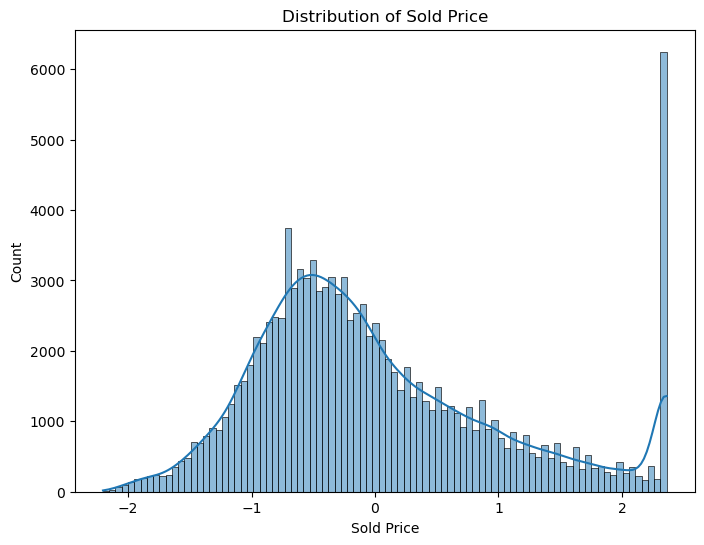

In [11]:
# Target variable analysis
plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Sold Price'], kde=True)
plt.title('Distribution of Sold Price')
plt.show()

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


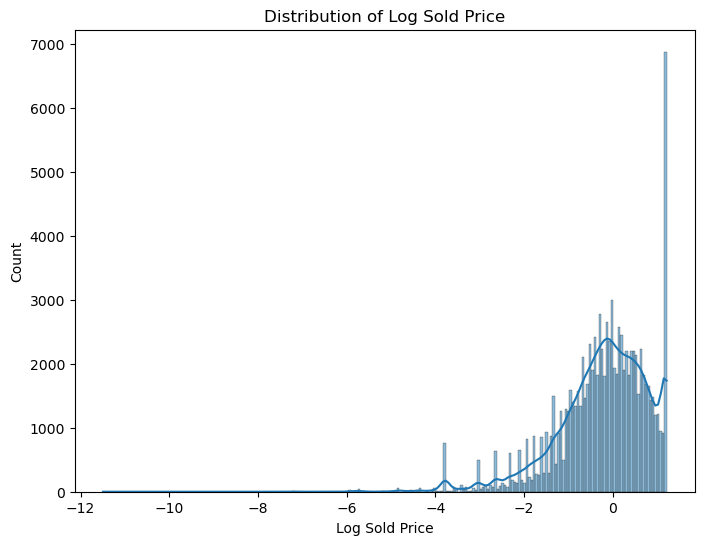

In [12]:
# Log transformation if skewed
housing_data['Log Sold Price'] = np.log1p(housing_data['Sold Price'])

plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Log Sold Price'], kde=True)
plt.title('Distribution of Log Sold Price')
plt.show()

In [13]:
#Show all the values in the Sold Price column
housing_data['Sold Price']

0        -0.608799
1         2.361454
2         2.361454
3         2.361454
4         2.361454
            ...   
112525    2.361454
112526    2.361454
112527    2.361454
112528    2.361454
112529   -0.320311
Name: Sold Price, Length: 112530, dtype: float64

In [14]:
#Create a correlation matrix to see what the correlation is for Price per SqFt
corr_matrix = housing_data.corr()
corr_matrix["Sold Price"].sort_values(ascending=False)

Sold Price          1.000000
List Price          0.992226
Log Sold Price      0.849815
SqFt                0.795880
Total Baths         0.707894
                      ...   
City_Henderson     -0.097549
City_Rocky Mount   -0.099812
City_Burlington    -0.101454
Lon                -0.140994
Age of Property    -0.262836
Name: Sold Price, Length: 395, dtype: float64

In [15]:
# Save the DataFrame to a CSV file
housing_data.to_csv('Clean_Data/mls_th_cleaned_3a.csv', index=False)